# Exploring Bikeshare Trip Data
**Extra Credit Project**

**CSE 6040, Spring 2022**

# Introduction

[Lyft's Bay Wheels bikeshare system](https://www.lyft.com/bikes/bay-wheels) provides access to both conventional and electric bikes at various stations around the San Francisco Bay Area. [Anonymized trip data](https://www.lyft.com/bikes/bay-wheels/system-data) from the system is available, which includes information such as type of bike, type of user, and start and end points. The bike docks are located in three distinct areas: San Francisco, San Jose, and East Bay (Oakland and Berkeley.)

To determine where high and low traffic stations are, we can do a simple ranking of how many times each station appears in a trip. We can also use a Markov chain analysis on the entire data set. This will tell us which destination stations the bikes tend to end up at, which might be useful if we want to determine where bikes pile up and need to be moved, or where changes to the station arrangement might be helpful to improve the flow. Much of this analysis is similar to the Ranking Relational Objects module.

However, we can go further and explore the behavior of different types of users, and electric vs. conventional bikes. Do these users behave differently? Do different types of bikes have different patterns? Since we're looking at data from San Francisco, we might expect a lot of tourists using bikes, but they might be more likely to be casual users since they don't live in the city. If we can identify some common tourist traffic patterns, that might help to optimize the system, and possibly adjust it for tourist seasons. People who use the system regularly might be more likely to be members, and it would be useful to know what they most often use the system for. Is it used mostly for commuting or grocery shopping? If they're likely to be carrying items with them on the bikes, bikes with baskets in certain areas might be useful to drive more traffic. Electric bikes require charging, so putting chargers at the highest traffic electric bike stations might keep them running longer without intervention.

Since the bikes stay in their respective regions, we actually have three separate networks in this data set, which will each have their own high and low traffic stations. Thus, we have 15 different subsets of the data to compare if we want to look at total traffic, traffic for each type of rider, and traffic for each type of bike.

## Constraints

Due to the constraints on this project, some options were not possible:

1. Data file uploads are limited to 10 MB, so only part of the total dataset was used.
2. Python packages are restricted to those that are installed in the Vocareum environment, which eliminated certain options like geopy, which would provide some nice reverse geocoding options.


# Initializing and Cleaning the Data

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.sparse
import networkx as nx
import itertools as it
import matplotlib.pyplot as plt

np.random.seed(42)

Reverse geocoding doesn't seem to be a viable solution in Vocareum. Thus, we'll use a crude approach to determine which region each subset of stations belongs to: finding the city center with the shortest distance. Fortunately, there are only three city centers that we need to worry about, so we can hard code them easily with latitude/longitude coordinates from https://latitudelongitude.org/.

In [2]:
oakland = (37.80437, -122.2708)
san_fran = (37.77493, -122.41942)
san_jose = (37.33939, -121.89496)

Since we will be running Markov chain ranking analysis and repeating calculuations and formatting on multiple different subsets of the data, we'll define some functions to use throughout the notebook.

In [3]:
# We don't have integer identifiers for the stations, so we'll need to make some.
def make_station_ids(df, origin_col, dest_col):
    # check existence of keys
    assert origin_col in df.keys(), 'Key "' + origin_col + '" not found'
    assert dest_col in df.keys(), 'Key "' + dest_col + '" not found'
    
    station_ids = pd.Series.to_frame(pd.concat([df[origin_col], df[dest_col]], axis=0, ignore_index=True), name='s_id')
    station_ids.drop_duplicates(subset='s_id', ignore_index=True, inplace=True)
    station_ids['i_id'] = station_ids.index
    return station_ids


# Make a segments matrix that we can use with the markov_chain function
def make_segments(df, origin_col, dest_col, gr_col):
    # origin_col and dest_col contain origin and destination identifiers, gr_col will be used for grouping
    # check existence of keys
    assert origin_col in df.keys(), 'Key "'+ origin_col + '" not found'
    assert dest_col in df.keys(), 'Key "'+ dest_col + '" not found'
    assert gr_col in df.keys(), 'Key "' + gr_col + '" not found'
    
    # getting the trip counts
    segment_groups = df[[origin_col, dest_col, gr_col]].groupby([origin_col, dest_col], as_index=False)
    segments = segment_groups.count()
    segments.rename(columns={gr_col: 'count'}, inplace=True)

    origins = segments[[origin_col, 'count']].groupby(origin_col, as_index=False).sum()
    origins.rename(columns={'count': 'origin_count'}, inplace=True)

    dests = segments[[dest_col, 'count']].groupby(dest_col, as_index=False).sum()
    dests.rename(columns={'count': 'dest_count'}, inplace=True)
    
    # make unique integer identifiers for the stations and match these with the origins and destinations
    station_ids = make_station_ids(df, origin_col, dest_col)

    segments = segments.merge(station_ids, left_on=origin_col, right_on='s_id', how='left')
    segments.rename(columns={'i_id': 'origin_index'}, inplace=True)
    segments = segments.merge(station_ids, left_on=dest_col, right_on='s_id', how='left')
    segments.rename(columns={'i_id': 'dest_index'}, inplace=True)

    # calculate the outdegree and weights
    segments["outdegree"] = segments.groupby('origin_index')['origin_index'].transform('count')
    segments["weight"] = 1 / segments['outdegree']
    return segments

# Apply a markov chain process to a segments dataframe t_max times
def markov_chain(segments_df, n, t_max):
    # check to see if the segments df has the correct keys
    assert 'weight' in segments_df.keys(), 'Key "weight" not found'
    assert 'origin_index' in segments_df.keys(), 'Key "origin_index" not found'
    assert 'dest_index' in segments_df.keys(), 'Key "dest_index" not found'
    assert n >= 0 and isinstance(n, int), 'n must be non-negative integer value'
    assert t_max >= 0 and isinstance(t_max, int), 't_max must be non-negative integer value'
    
    # make the sparse matrix P and x0
    P = sp.sparse.coo_matrix((segments_df.weight, (segments_df.origin_index, segments_df.dest_index)), shape=(n, n))

    outgoings_i = segments_df.origin_index.unique()
    prob = 1 / len(outgoings_i)
    x0 = np.zeros(n)

    for i in outgoings_i:
        x0[i] = prob

    # calculate x
    return (P.T ** t_max) @ x0


# Find the top 10 destination stations from Markov chain output
def m_get_top_10(x, df, code):
    ranks = np.argsort(-x)
    top10 = pd.DataFrame({'Rank': np.arange(1, 11),
                          code: df.iloc[ranks[:10]][code],
                          'x(t)': x[ranks[:10]]})
    return top10

# Find the bottom 10 destination stations from Markov chain output
def m_get_bottom_10(x, df, code):
    ranks = np.argsort(x)
    bottom10 = pd.DataFrame({'Rank': np.arange(1, 11),
                             code: df.iloc[ranks[:10]][code],
                             'x(t)': x[ranks[:10]]})
    return bottom10


# Simple top and bottom 10 functions that work with segments dataframe counts directly
def simple_get_top_10(segments_df, count, code):
    sorted_df = segments_df[[code, count]].groupby(code).sum().reset_index()
    sorted_df = sorted_df.sort_values(by=count, ascending=False).head(10)
    sorted_df['Rank'] = range(1, 10+1)
    return sorted_df[['Rank', code, count]]

def simple_get_bottom_10(segments_df, count, code):
    sorted_df = segments_df[[code, count]].groupby(code).sum().reset_index()
    sorted_df = sorted_df.sort_values(by=count, ascending=True).head(10)
    sorted_df['Rank'] = range(1, 10+1)
    return sorted_df[['Rank', code, count]]

# Calculate a simple percentage similarity between two lists
def similarity(a, b):
    sa = set(a)
    sb = set(b)
    return 100 * len(sa & sb) / len(sa | sb)

# Get similarity scores between all pairs of sets in a list
def combo_array(comp_list):
    # get all the ways we can choose a pair of items out of n items
    n = len(comp_list)
    combos = list(it.combinations(range(n), 2))
    
    # initialize a numpy array to organize all of the pairs in a grid
    c_array = 100*np.identity(n)

    for c in combos:
        s = round(similarity(comp_list[c[0]], comp_list[c[1]]), 2)
        c_array[c[0], c[1]] = s
        c_array[c[1], c[0]] = s
    
    return c_array
    

The original datasets from [Lyft](https://www.lyft.com/bikes/bay-wheels/system-data) are very large, and could not be used for this project due to space constraints. The dataset used here is derived from the March 2022 data set, which started at 38.6 MB. To make the dataset more usable, all rows with missing data were dropped, and 75% of the remaining data was removed (randomly chosen) in order to reduce the size to 7.8 MB. 

Obviously, this can't be accomplished in a Vocareum environment with a 10 MB space constraint, so the pre-processing was done locally, and the code is provided here, but commented out.

In [4]:
'''# import the original dataset, remove entries with nan and reduce the file size below 10MB
alltrips_df = pd.read_csv('202203-baywheels-tripdata.csv')
cleaned_df = alltrips_df.dropna()
n = math.floor(len(cleaned_df.index) * 0.75)
drops = np.random.choice(cleaned_df.index, n, replace=False)
cleaned_df = cleaned_df.drop(drops)
cleaned_df.to_csv('tripdata.csv', index=False)
'''

trip_df = pd.read_csv('tripdata.csv')
trip_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,AFFAB6626FEBCC2E,classic_bike,2022-03-25 05:48:34,2022-03-25 06:01:54,24th St at Chattanooga St,SF-Q21-2,Market St at 10th St,SF-J23-1,37.751819,-122.426614,37.776619,-122.417385,member
1,410DB9F2CA579E79,classic_bike,2022-03-16 20:05:16,2022-03-16 20:32:50,Haste St at Telegraph Ave,BK-E9-2,Frank H Ogawa Plaza,OK-L5,37.866043,-122.258804,37.804562,-122.271738,member
2,35419DFB2F9E5FF3,electric_bike,2022-03-13 17:38:02,2022-03-13 17:45:21,Esprit Park,SF-O30,Rhode Island St at 17th St,SF-N27,37.761670,-122.390835,37.764478,-122.402570,member
3,E04B2BFF4862CEC7,classic_bike,2022-03-11 17:08:26,2022-03-11 17:23:12,Broadway at Coronado Ave,OK-D5,34th St at Telegraph Ave,OK-H4-3,37.835788,-122.251621,37.822468,-122.265971,member
4,8C41B936B11FE71D,electric_bike,2022-03-07 15:58:59,2022-03-07 16:15:21,Bryant St at 6th St,SF-J27,Haight St at Lyon St,SF-K17-2,37.775874,-122.402654,37.770519,-122.442326,casual


This dataset lends itself well to a graph structure, and we can visualize the data using NetworkX.

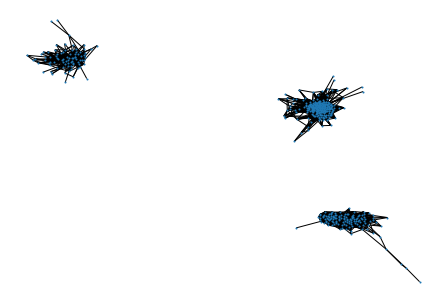

In [5]:
trip_gr = nx.from_pandas_edgelist(trip_df, source='start_station_id', target='end_station_id')

nx.draw_spring(trip_gr, with_labels=False, node_size=1)

We can clearly see the three regions, as expected. These are all disconnected, so we can separate these into distinct graphs and check to make sure that we have the correct number.

In [6]:
# split into subgraphs
sub_trip_gr = (trip_gr.subgraph(c).copy() for c in nx.connected_components(trip_gr))

sub_regions = [list(sg.nodes) for sg in list(sub_trip_gr)]

print('There are ' + str(len(sub_regions)) + ' distinct subgraphs.')

There are 3 distinct subgraphs.


Let's determine which region each subgraph belongs to, so that we can update our dataframe with region identifiers.

In [7]:
# Make a list of corresponding cities to go with our sub regions
cities = []

for i in range(len(sub_regions)):
    # Find the coordinates of a sample station in the sub region
    location = (trip_df[(trip_df['start_station_id'] == sub_regions[i][1])]['start_lat'].values[0], 
                trip_df[(trip_df['start_station_id'] == sub_regions[i][1])]['start_lng'].values[0])
    
    # Calculate the distances from the location to each of the city centers
    oak_dist = (location[0] - oakland[0])**2 + (location[1] - oakland[1])**2
    sf_dist = (location[0] - san_fran[0])**2 + (location[1] - san_fran[1])**2
    sj_dist = (location[0] - san_jose[0])**2 + (location[1] - san_jose[1])**2
    dist_list = [oak_dist, sf_dist, sj_dist]

    # Which city does it belong to?
    if oak_dist == min(dist_list):
        cities.append("East Bay")
    elif sf_dist == min(dist_list):
        cities.append("San Francisco")
    else:
        cities.append("San Jose")

# Update the dataframe with our region information
trip_df['region'] = np.where(trip_df['start_station_id'].isin(sub_regions[0]), cities[0], 0)
trip_df['region'] = np.where(trip_df['start_station_id'].isin(sub_regions[1]), cities[1], trip_df['region'])
trip_df['region'] = np.where(trip_df['start_station_id'].isin(sub_regions[2]), cities[2], trip_df['region'])

trip_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,region
0,AFFAB6626FEBCC2E,classic_bike,2022-03-25 05:48:34,2022-03-25 06:01:54,24th St at Chattanooga St,SF-Q21-2,Market St at 10th St,SF-J23-1,37.751819,-122.426614,37.776619,-122.417385,member,San Francisco
1,410DB9F2CA579E79,classic_bike,2022-03-16 20:05:16,2022-03-16 20:32:50,Haste St at Telegraph Ave,BK-E9-2,Frank H Ogawa Plaza,OK-L5,37.866043,-122.258804,37.804562,-122.271738,member,East Bay
2,35419DFB2F9E5FF3,electric_bike,2022-03-13 17:38:02,2022-03-13 17:45:21,Esprit Park,SF-O30,Rhode Island St at 17th St,SF-N27,37.761670,-122.390835,37.764478,-122.402570,member,San Francisco
3,E04B2BFF4862CEC7,classic_bike,2022-03-11 17:08:26,2022-03-11 17:23:12,Broadway at Coronado Ave,OK-D5,34th St at Telegraph Ave,OK-H4-3,37.835788,-122.251621,37.822468,-122.265971,member,East Bay
4,8C41B936B11FE71D,electric_bike,2022-03-07 15:58:59,2022-03-07 16:15:21,Bryant St at 6th St,SF-J27,Haight St at Lyon St,SF-K17-2,37.775874,-122.402654,37.770519,-122.442326,casual,San Francisco


# Initial Systemwide Rankings

Now, let's test our Markov chain process on the entire system. These results won't make much sense, as bikes will be "trapped" in one cluster and won't be able to flow properly throughout the whole system.

In [8]:
# Use our previously defined Markov chain helper functions...
all_segs_df = make_segments(trip_df, 'start_station_name', 'end_station_name', 'ride_id')
all_stat_ids = make_station_ids(trip_df, 'start_station_name', 'end_station_name')

n_all = len(all_stat_ids.index)

x_all = markov_chain(all_segs_df, n_all, 100)

print("\n ==Markov Top Ten Destination Stations== \n")
print(m_get_top_10(x_all, all_stat_ids, 's_id'))

print("\n ==Markov Bottom Ten Destination Stations== \n")
print(m_get_bottom_10(x_all, all_stat_ids, 's_id'))


 ==Markov Top Ten Destination Stations== 

     Rank                                          s_id      x(t)
177     1                Foothill Blvd at Fruitvale Ave  0.045498
52      2                        MacArthur BART Station  0.005624
279     3                     San Fernando St at 7th St  0.005572
325     4                     San Fernando St at 4th St  0.005068
54      5                       Market St at Steuart St  0.005031
95      6                          Market St at 10th St  0.004969
171     7  Powell St BART Station (Market St at 5th St)  0.004819
166     8  Powell St BART Station (Market St at 4th St)  0.004746
179     9                        The Alameda at Bush St  0.004363
69     10                          Post St at Kearny St  0.004344

 ==Markov Bottom Ten Destination Stations== 

     Rank                                s_id          x(t)
386     1                10th St at Empire St  0.000000e+00
419     2          Farnam St at Fruitvale Ave  0.000000e+00
485

If you're familiar with the SF Bay Area, some of these street names might look familiar. The top two stations are in Oakland, the next two are in San Jose, and then we see several stops on Market Street in San Francisco. The number one spot has a dramatically larger weight than the others, which is strange.

We can also find the top ten and bottom ten origin and destination stations by using a simple ride count.

In [9]:
print("\n ==Top Ten Destination Stations== \n")
print(simple_get_top_10(all_segs_df, 'count', "end_station_name"))

print("\n ==Bottom Ten Destination Stations== \n")
print(simple_get_bottom_10(all_segs_df, 'count', "end_station_name"))

print("\n ==Top Ten Origin Stations== \n")
print(simple_get_top_10(all_segs_df, 'count', "start_station_name"))

print("\n ==Bottom Ten Origin Stations== \n")
print(simple_get_bottom_10(all_segs_df, 'count', "start_station_name"))


 ==Top Ten Destination Stations== 

     Rank                                   end_station_name  count
304     1                               Market St at 10th St    564
311     2                            Market St at Steuart St    533
370     3       Powell St BART Station (Market St at 4th St)    465
371     4       Powell St BART Station (Market St at 5th St)    412
129     5                                 Berry St at 4th St    393
21      6                             17th St at Valencia St    374
331     7   Montgomery St BART Station (Market St at 2nd St)    343
366     8                               Post St at Kearny St    338
399     9  San Francisco Ferry Building (Harry Bridges Pl...    338
342    10                          North Point St at Polk St    318

 ==Bottom Ten Destination Stations== 

     Rank                    end_station_name  count
324     1                  Minnesota St Depot      1
390     2                    San Antonio Park      1
154     3       

This looks much more like we would expect: lots of Market Street stations in the top destination and origin lists. The Foothill and Fruitvale station is showing up in the bottom ten origin stations list, which suggests that something strange is happening in the East Bay cluster in the Markov chain process. Since Foothill and Fruitvale only shows up as an origin station once, this location may be accumulating bikes.

# Rankings for Regions

Now, let's look at specific subsections of the dataframe, starting with the three regions.

In [10]:
# Dataframes for the trip data that belongs to each region
sf_df = trip_df[(trip_df['region'] == 'San Francisco')]
sj_df = trip_df[(trip_df['region'] == 'San Jose')]
eb_df = trip_df[(trip_df['region'] == 'East Bay')]

# San Francisco Rankings

sf_segs_df = make_segments(sf_df, 'start_station_name', 'end_station_name', 'ride_id')
sf_stat_ids = make_station_ids(sf_df, 'start_station_name', 'end_station_name')

n_sf = len(sf_stat_ids.index)

x_sf = markov_chain(sf_segs_df, n_sf, 100)

# Define our top and bottom lists and store them for use later
sf_m_top = m_get_top_10(x_sf, sf_stat_ids, 's_id')
sf_m_bot = m_get_bottom_10(x_sf, sf_stat_ids, 's_id')
sf_ds_top = simple_get_top_10(sf_segs_df, 'count', "end_station_name")
sf_ds_bot = simple_get_bottom_10(sf_segs_df, 'count', "end_station_name")
sf_os_top = simple_get_top_10(sf_segs_df, 'count', "start_station_name")
sf_os_bot = simple_get_bottom_10(sf_segs_df, 'count', "start_station_name")

print("\n === San Francisco Rankings === \n")

print("\n ==Markov Top Ten Destination Stations== \n")
print(sf_m_top)

print("\n ==Markov Bottom Ten Destination Stations== \n")
print(sf_m_bot)

print("\n ==Top Ten Destination Stations== \n")
print(sf_ds_top)

print("\n ==Bottom Ten Destination Stations== \n")
print(sf_ds_bot)

print("\n ==Top Ten Origin Stations== \n")
print(sf_os_top)

print("\n ==Bottom Ten Origin Stations== \n")
print(sf_os_bot)


 === San Francisco Rankings === 


 ==Markov Top Ten Destination Stations== 

     Rank                                               s_id      x(t)
41      1                            Market St at Steuart St  0.008796
72      2                               Market St at 10th St  0.008686
124     3       Powell St BART Station (Market St at 5th St)  0.008424
119     4       Powell St BART Station (Market St at 4th St)  0.008297
54      5                               Post St at Kearny St  0.007594
49      6                Union Square (Powell St at Post St)  0.007399
65      7   Montgomery St BART Station (Market St at 2nd St)  0.007354
96      8                             17th St at Valencia St  0.007300
68      9  San Francisco Ferry Building (Harry Bridges Pl...  0.007246
67     10                               Grove St at Gough St  0.007222

 ==Markov Bottom Ten Destination Stations== 

     Rank                                               s_id          x(t)
214     1         

In [11]:
# San Jose Rankings

sj_segs_df = make_segments(sj_df, 'start_station_name', 'end_station_name', 'ride_id')
sj_stat_ids = make_station_ids(sj_df, 'start_station_name', 'end_station_name')

n_sj = len(sj_stat_ids.index)

x_sj = markov_chain(sj_segs_df, n_sj, 100)

# Define our top and bottom lists and store them for use later
sj_m_top = m_get_top_10(x_sj, sj_stat_ids, 's_id')
sj_m_bot = m_get_bottom_10(x_sj, sj_stat_ids, 's_id')
sj_ds_top = simple_get_top_10(sj_segs_df, 'count', "end_station_name")
sj_ds_bot = simple_get_bottom_10(sj_segs_df, 'count', "end_station_name")
sj_os_top = simple_get_top_10(sj_segs_df, 'count', "start_station_name")
sj_os_bot = simple_get_bottom_10(sj_segs_df, 'count', "start_station_name")

print("\n === San Jose Rankings === \n")

print("\n ==Markov Top Ten Destination Stations== \n")
print(sj_m_top)

print("\n ==Markov Bottom Ten Destination Stations== \n")
print(sj_m_bot)

print("\n ==Top Ten Destination Stations== \n")
print(sj_ds_top)

print("\n ==Bottom Ten Destination Stations== \n")
print(sj_ds_bot)

print("\n ==Top Ten Origin Stations== \n")
print(sj_os_top)

print("\n ==Bottom Ten Origin Stations== \n")
print(sj_os_bot)


 === San Jose Rankings === 


 ==Markov Top Ten Destination Stations== 

    Rank                          s_id      x(t)
30     1     San Fernando St at 7th St  0.034279
35     2     San Fernando St at 4th St  0.031177
17     3        The Alameda at Bush St  0.026840
19     4                   Cahill Park  0.023941
33     5      Julian St at The Alameda  0.022207
9      6            San Jose City Hall  0.021387
5      7     San Salvador St at 9th St  0.021334
3      8  W Julian St at N Morrison St  0.020968
12     9      Santa Clara St at 7th St  0.019508
7     10      San Jose Diridon Station  0.017042

 ==Markov Bottom Ten Destination Stations== 

    Rank                            s_id          x(t)
66     1        Columbia Ave at Bird Ave  0.000000e+00
52     2            10th St at Empire St  0.000000e+00
27     3     Auzerais Ave at Lincoln Ave  0.000000e+00
21     4       Delmas Ave at Virginia St  9.985581e-33
81     5            23rd St at Taylor St  5.639838e-04
79     6  

In [12]:
# East Bay Rankings

eb_segs_df = make_segments(eb_df, 'start_station_name', 'end_station_name', 'ride_id')
eb_stat_ids = make_station_ids(eb_df, 'start_station_name', 'end_station_name')

n_eb = len(eb_stat_ids.index)

x_eb = markov_chain(eb_segs_df, n_eb, 100)

# Define our top and bottom lists and store them for use later
eb_m_top = m_get_top_10(x_eb, eb_stat_ids, 's_id')
eb_m_bot = m_get_bottom_10(x_eb, eb_stat_ids, 's_id')
eb_ds_top = simple_get_top_10(eb_segs_df, 'count', "end_station_name")
eb_ds_bot = simple_get_bottom_10(eb_segs_df, 'count', "end_station_name")
eb_os_top = simple_get_top_10(eb_segs_df, 'count', "start_station_name")
eb_os_bot = simple_get_bottom_10(eb_segs_df, 'count', "start_station_name")

print("\n === East Bay Rankings === \n")

print("\n ==Markov Top Ten Destination Stations== \n")
print(eb_m_top)

print("\n ==Markov Bottom Ten Destination Stations== \n")
print(eb_m_bot)

print("\n ==Top Ten Destination Stations== \n")
print(eb_ds_top)

print("\n ==Bottom Ten Destination Stations== \n")
print(eb_ds_bot)

print("\n ==Top Ten Origin Stations== \n")
print(eb_os_top)

print("\n ==Bottom Ten Origin Stations== \n")
print(eb_os_bot)


 === East Bay Rankings === 


 ==Markov Top Ten Destination Stations== 

    Rank                            s_id      x(t)
32     1  Foothill Blvd at Fruitvale Ave  0.171411
6      2          MacArthur BART Station  0.021187
39     3     El Embarcadero at Grand Ave  0.015359
57     4           Ninth St at Heinz Ave  0.014530
23     5        Telegraph Ave at 19th St  0.013646
51     6         Grand Ave at Webster St  0.013387
46     7             Broadway at 40th St  0.013288
42     8             Bay Pl at Vernon St  0.013254
85     9        Telegraph Ave at 23rd St  0.013032
30    10        Telegraph Ave at 49th St  0.012933

 ==Markov Bottom Ten Destination Stations== 

     Rank                                       s_id      x(t)
128     1            Foothill Blvd at Harrington Ave  0.000000
33      2                  23rd Ave at Foothill Blvd  0.000000
105     3                 Farnam St at Fruitvale Ave  0.000000
122     4                           San Antonio Park  0.000403
114

### What's Happening at Foothill and Fruitvale?

As expected, Foothill and Fruitvale has an overwhelming share of traffic in the Markov Chain analysis, but doesn't make the top ten destination stations *and* makes the bottom ten origin stations. Something strange is happening with this station, let's look at which stations link to it and what their connection counts are.

The "ego graph" function in NetworkX will let us visualize this.  This function gives us a subgraph, with nodes $n$ neighbourhoods out from the specificed node. (Graph theory note: the "neighbourhood" of a node is the node itself along with all of its adjacent nodes, and any edges that connect the nodes within this group.)

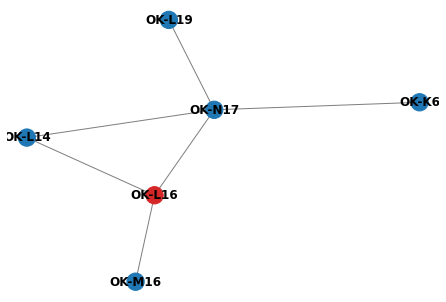

In [13]:
foot_fruit_id = trip_df[(trip_df['start_station_name'] == "Foothill Blvd at Fruitvale Ave")] \
                ['start_station_id'].values[0]

# Try n=2 nodes out
foot_fruit_gr_2 = nx.ego_graph(trip_gr, foot_fruit_id, 2)
color_map_2 = ['tab:red' if node == foot_fruit_id else 'tab:blue' for node in foot_fruit_gr_2]

nx.draw_kamada_kawai(foot_fruit_gr_2, with_labels=True, font_weight='bold', node_color=color_map_2, 
                     edge_color='tab:grey')

The Foothill and Fruitvale station (in red) only connects directly to three other stations, and if we go two neighbourhoods out, we only get two more. How far out do we need to go to connect up to a bigger cluster?

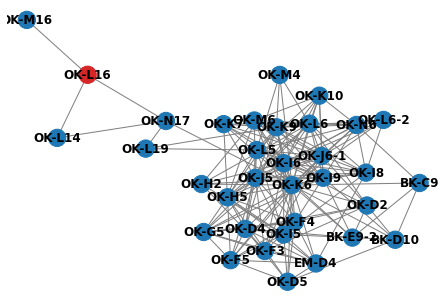

In [14]:
foot_fruit_gr_3 = nx.ego_graph(trip_gr, foot_fruit_id, 3)
color_map_3 = ['tab:red' if node == foot_fruit_id else 'tab:blue' for node in foot_fruit_gr_3]

nx.draw_kamada_kawai(foot_fruit_gr_3, with_labels=True, font_weight='bold', node_color=color_map_3, 
                     edge_color='tab:grey')

Not very far apparently! Once we go one more neighborhood out, the two nodes that were added on the previous step connect up to many nodes, in particular, node OK-K6, which corresponds to Webster St at 19th St. Not a particularly notable station. OK_L19 also has some connections to the outside world.

Let's look at incoming and outgoing counts involving these nodes.

In [15]:
# Get a subset of the East Bay data that only includes the nodes that exist in our n=3 subgroup
foot_fruit_fam = eb_df[(eb_df['start_station_id'].isin(list(foot_fruit_gr_3)))]
foot_fruit_fam = pd.concat([foot_fruit_fam, eb_df[eb_df['end_station_id'].isin(list(foot_fruit_gr_3))]]) \
                .drop_duplicates()

# Make this into a segments dataframe and get sums of occurences as start and end stations
ff_segs_df = make_segments(foot_fruit_fam, 'start_station_id', 'end_station_id', 'ride_id')

web_start_df = ff_segs_df[['start_station_id', 'count']].groupby('start_station_id').sum().reset_index()
web_end_df = ff_segs_df[['end_station_id', 'count']].groupby('end_station_id').sum().reset_index()

# Get the human-friendly names for these stations
k6 = foot_fruit_fam[foot_fruit_fam['start_station_id']=='OK-K6']['start_station_name'].values[0]
l19 = foot_fruit_fam[foot_fruit_fam['start_station_id']=='OK-L19']['start_station_name'].values[0]

print('\n === Where Are These Stations? === \n')
print(f'OK-K6 is {k6} and OK-L19 is {l19}')

print('\n === Start and End Counts === \n')
print(web_start_df[web_start_df['start_station_id'].isin(['OK-K6', 'OK-L19'])])
print(web_end_df[web_end_df['end_station_id'].isin(['OK-K6', 'OK-L19'])])

# Get a subset of the East Bay data that only includes the nodes that exist in our n=2 subgroup
ff_segs_2 = ff_segs_df[ff_segs_df['end_station_id'].isin(list(foot_fruit_gr_2))]
ff_segs_2 = ff_segs_2[ff_segs_2['start_station_id'].isin(list(foot_fruit_gr_2))]

# Get sums of occurences as start and end stations
web_start_2 = ff_segs_2[['start_station_id', 'count']].groupby('start_station_id').sum().reset_index()
web_end_2 = ff_segs_2[['end_station_id', 'count']].groupby('end_station_id').sum().reset_index()

print('\n === Start and End Counts: Small Cluster === \n')
print(web_start_2[web_start_2['start_station_id'].isin(['OK-K6', 'OK-L19'])])
print(web_end_2[web_end_2['end_station_id'].isin(['OK-K6', 'OK-L19'])])


 === Where Are These Stations? === 

OK-K6 is Webster St at 19th St and OK-L19 is Bond St at High St

 === Start and End Counts === 

    start_station_id  count
93             OK-K6     23
102           OK-L19      3
    end_station_id  count
94           OK-K6     19
101         OK-L19      4

 === Start and End Counts: Small Cluster === 

  start_station_id  count
0            OK-K6      2
3           OK-L19      3
  end_station_id  count
0          OK-K6      1
2         OK-L19      2


This Webster and 19th station has more outgoing trips than incoming, but only 2 of them are directed towards nodes in the small cluster around Foothill and Fruitvale. Bond and High doesn't have nearly as much traffic, but all of its outgoing traffic is connected to our small cluster. Both of these stations input slightly more traffic to the small cluster than they output. Apparently this is enough to concentrate a lot of traffic at Foothill and Fruitvale over time in the Markov chain model!

This anomaly in the Markov chain model may or may not occur when the entire dataset (or datasets across multiple months) are run. However, it does demonstrate how a small, isolated cluster of stations can absorb destination traffic over time.

# Which Stations are Popular With Subgroups?

We also have the categories of rider (member/casual) and bicycle type (classic, electric, and docked, but we'll just look at classic and electric.) Which stations are the most highly used by these riders and bicycle types in these three regions? Unfortunately (though, understandably) we can't tell how many distinct riders and bikes are in the system. This is a good sign though, since it makes it difficult to match user ids to individuals.

## Rider Types

In [16]:
# As above... so here
# subsets for members and casual riders for each region
sf_mem = sf_df[(sf_df['member_casual'] == 'member')]
sf_cas = sf_df[(sf_df['member_casual'] == 'casual')]
sj_mem = sj_df[(sj_df['member_casual'] == 'member')]
sj_cas = sj_df[(sj_df['member_casual'] == 'casual')]
eb_mem = eb_df[(eb_df['member_casual'] == 'member')]
eb_cas = eb_df[(eb_df['member_casual'] == 'casual')]

# make the segments dataframes
sf_segs_mem = make_segments(sf_mem, 'start_station_name', 'end_station_name', 'ride_id')
sf_segs_cas = make_segments(sf_cas, 'start_station_name', 'end_station_name', 'ride_id')
sj_segs_mem = make_segments(sj_mem, 'start_station_name', 'end_station_name', 'ride_id')
sj_segs_cas = make_segments(sj_cas, 'start_station_name', 'end_station_name', 'ride_id')
eb_segs_mem = make_segments(eb_mem, 'start_station_name', 'end_station_name', 'ride_id')
eb_segs_cas = make_segments(eb_cas, 'start_station_name', 'end_station_name', 'ride_id')

# rankings
sf_mem_top_star = simple_get_top_10(sf_segs_mem, 'count', "start_station_name")
sf_cas_top_star = simple_get_top_10(sf_segs_cas, 'count', "start_station_name")
sj_mem_top_star = simple_get_top_10(sj_segs_mem, 'count', "start_station_name")
sj_cas_top_star = simple_get_top_10(sj_segs_cas, 'count', "start_station_name")
eb_mem_top_star = simple_get_top_10(eb_segs_mem, 'count', "start_station_name")
eb_cas_top_star = simple_get_top_10(eb_segs_cas, 'count', "start_station_name")

sf_mem_top_end = simple_get_top_10(sf_segs_mem, 'count', "end_station_name")
sf_cas_top_end = simple_get_top_10(sf_segs_cas, 'count', "end_station_name")
sj_mem_top_end = simple_get_top_10(sj_segs_mem, 'count', "end_station_name")
sj_cas_top_end = simple_get_top_10(sj_segs_cas, 'count', "end_station_name")
eb_mem_top_end = simple_get_top_10(eb_segs_mem, 'count', "end_station_name")
eb_cas_top_end = simple_get_top_10(eb_segs_cas, 'count', "end_station_name")

print("\n === San Francisco Rankings === \n")

print("\n ==Members Top 10 Origins== \n")
print(sf_mem_top_star)

print("\n ==Casual Top 10 Origins== \n")
print(sf_cas_top_star)

print("\n ==Members Top 10 Destinations== \n")
print(sf_mem_top_end)

print("\n ==Casual Top 10 Destinations== \n")
print(sf_cas_top_end)

print("\n\n === San Jose Rankings === \n")

print("\n ==Members Top 10 Origins== \n")
print(sj_mem_top_star)

print("\n ==Casual Top 10 Origins== \n")
print(sj_cas_top_star)

print("\n ==Members Top 10 Destinations== \n")
print(sj_mem_top_end)

print("\n ==Casual Top 10 Destinations== \n")
print(sj_cas_top_end)

print("\n\n === East Bay Rankings === \n")

print("\n ==Members Top 10 Origins== \n")
print(eb_mem_top_star)

print("\n ==Casual Top 10 Origins== \n")
print(eb_cas_top_star)

print("\n ==Members Top 10 Destinations== \n")
print(eb_mem_top_end)

print("\n ==Casual Top 10 Destinations== \n")
print(eb_cas_top_end)


 === San Francisco Rankings === 


 ==Members Top 10 Origins== 

     Rank                                start_station_name  count
178     1                              Market St at 10th St    383
218     2      Powell St BART Station (Market St at 4th St)    296
181     3                           Market St at Steuart St    295
69      4                                Berry St at 4th St    254
194     5  Montgomery St BART Station (Market St at 2nd St)    229
219     6      Powell St BART Station (Market St at 5th St)    210
192     7                                Mission Playground    196
230     8   Salesforce Transit Center (Natoma St at 2nd St)    195
98      9                        Division St at Potrero Ave    194
169    10                             Laguna St at Hayes St    191

 ==Casual Top 10 Origins== 

     Rank                                 start_station_name  count
181     1                            Market St at Steuart St    200
218     2       Powell St BART 

San Francisco has some commonalities between members and casual users, but also some differences that aren't so surprising. Among members, Berry St at 4th St (right next to the Lyft headquarters... coincidence?) and the Salesforce Transit Center are popular, which suggests that we might have a lot of professional commuters in the members group. Among casual users, the San Francisco Ferry, Pier 1/2, and Union Square are all very popular, which suggests a lot of tourists in the casual group. We could test this theory with some more detailed user data.

San Jose rides also share a lot of commonalities, though with many fewer rides. This makes it more difficult to speculate about differences between members and casual users here. East Bay also has a lot of commonalities, and it's difficult to detect a lot of difference in the user bases intuitively from these lists.

## Bike Types

In [17]:
# Again... subsets for classic and electric bikes
sf_class = sf_df[(sf_df['rideable_type'] == 'classic_bike')]
sf_elec = sf_df[(sf_df['rideable_type'] == 'electric_bike')]
sj_class = sj_df[(sj_df['rideable_type'] == 'classic_bike')]
sj_elec = sj_df[(sj_df['rideable_type'] == 'electric_bike')]
eb_class = eb_df[(eb_df['rideable_type'] == 'classic_bike')]
eb_elec = eb_df[(eb_df['rideable_type'] == 'electric_bike')]

# make segments...
sf_segs_class = make_segments(sf_class, 'start_station_name', 'end_station_name', 'ride_id')
sf_segs_elec = make_segments(sf_elec, 'start_station_name', 'end_station_name', 'ride_id')
sj_segs_class = make_segments(sj_class, 'start_station_name', 'end_station_name', 'ride_id')
sj_segs_elec = make_segments(sj_elec, 'start_station_name', 'end_station_name', 'ride_id')
eb_segs_class = make_segments(eb_class, 'start_station_name', 'end_station_name', 'ride_id')
eb_segs_elec = make_segments(eb_elec, 'start_station_name', 'end_station_name', 'ride_id')

# rankings
sf_class_top_star = simple_get_top_10(sf_segs_class, 'count', "start_station_name")
sf_elec_top_star = simple_get_top_10(sf_segs_elec, 'count', "start_station_name")
sj_class_top_star = simple_get_top_10(sj_segs_class, 'count', "start_station_name")
sj_elec_top_star = simple_get_top_10(sj_segs_elec, 'count', "start_station_name")
eb_class_top_star = simple_get_top_10(eb_segs_class, 'count', "start_station_name")
eb_elec_top_star = simple_get_top_10(eb_segs_elec, 'count', "start_station_name")

sf_class_top_end = simple_get_top_10(sf_segs_class, 'count', "end_station_name")
sf_elec_top_end = simple_get_top_10(sf_segs_elec, 'count', "end_station_name")
sj_class_top_end = simple_get_top_10(sj_segs_class, 'count', "end_station_name")
sj_elec_top_end = simple_get_top_10(sj_segs_elec, 'count', "end_station_name")
eb_class_top_end = simple_get_top_10(eb_segs_class, 'count', "end_station_name")
eb_elec_top_end = simple_get_top_10(eb_segs_elec, 'count', "end_station_name")

print("\n === San Francisco Rankings === \n")

print("\n ==Classic Top 10 Origins== \n")
print(sf_class_top_star)

print("\n ==Electric Top 10 Origins== \n")
print(sf_elec_top_star)

print("\n ==Classic Top 10 Destinations== \n")
print(sf_class_top_end)

print("\n ==Electric Top 10 Destinations== \n")
print(sf_elec_top_end)

print("\n\n === San Jose Rankings === \n")

print("\n ==Classic Top 10 Origins== \n")
print(sj_class_top_star)

print("\n ==Electric Top 10 Origins== \n")
print(sj_elec_top_star)

print("\n ==Classic Top 10 Destinations== \n")
print(sj_class_top_end)

print("\n ==Electric Top 10 Destinations== \n")
print(sj_elec_top_end)

print("\n\n === East Bay Rankings === \n")

print("\n ==Classic Top 10 Origins== \n")
print(eb_class_top_star)

print("\n ==Electric Top 10 Origins== \n")
print(eb_elec_top_star)

print("\n ==Classic Top 10 Destinations== \n")
print(eb_class_top_end)

print("\n ==Electric Top 10 Destinations== \n")
print(eb_elec_top_end)


 === San Francisco Rankings === 


 ==Classic Top 10 Origins== 

     Rank                                 start_station_name  count
176     1                               Market St at 10th St    257
179     2                            Market St at Steuart St    236
216     3       Powell St BART Station (Market St at 4th St)    229
68      4                                 Berry St at 4th St    174
217     5       Powell St BART Station (Market St at 5th St)    165
88      6  Civic Center/UN Plaza BART Station (Market St ...    142
12      7                             17th St at Valencia St    137
192     8   Montgomery St BART Station (Market St at 2nd St)    136
207     9                        Pier 1/2 at The Embarcadero    134
209    10                                 Polk St at Post St    132

 ==Electric Top 10 Origins== 

     Rank                                start_station_name  count
179     1                              Market St at 10th St    298
219     2      Powel

Again, we see quite a lot of commonality, and some differences. These might be due to a lack of charging stations in some areas, or an abundance of stations. We can safely say that there aren't any electric bikes in the East Bay.

# How do the Rankings Compare?

To compare the top ten lists, we can use a simple percentage similarity to see how many they have in common compared to their combined items: 

$$100 \cdot \frac{|A \cap B|}{|A \cup B|}$$

This is defined in our function section of the notebook as $\texttt{similarity()}$.

## Too Many Sets!

We made a lot of rankings, and now we need them organized together, so let's make them into some more manageable sets so that we can compare them.

In [18]:
# Organize into lists
category_labels = ["All", "Member", "Casual", "Classic", "Electric"]

sf_start_stations = [sf_os_top["start_station_name"], sf_mem_top_star["start_station_name"], 
                     sf_cas_top_star["start_station_name"], sf_class_top_star["start_station_name"], 
                     sf_elec_top_star["start_station_name"]]
sf_end_stations = [sf_ds_top["end_station_name"], sf_mem_top_end["end_station_name"], 
                   sf_cas_top_end["end_station_name"], sf_class_top_end["end_station_name"], 
                   sf_elec_top_end["end_station_name"]]
sj_start_stations = [sj_os_top["start_station_name"], sj_mem_top_star["start_station_name"], 
                     sj_cas_top_star["start_station_name"], sj_class_top_star["start_station_name"], 
                     sj_elec_top_star["start_station_name"]]
sj_end_stations = [sj_ds_top["end_station_name"], sj_mem_top_end["end_station_name"], 
                   sj_cas_top_end["end_station_name"], sj_class_top_end["end_station_name"], 
                   sj_elec_top_end["end_station_name"]]
eb_start_stations = [eb_os_top["start_station_name"], eb_mem_top_star["start_station_name"], 
                     eb_cas_top_star["start_station_name"], eb_class_top_star["start_station_name"], 
                     eb_elec_top_star["start_station_name"]]
eb_end_stations = [eb_ds_top["end_station_name"], eb_mem_top_end["end_station_name"], 
                   eb_cas_top_end["end_station_name"], eb_class_top_end["end_station_name"], 
                   eb_elec_top_end["end_station_name"]]
    
# Generate similarity scores for each list, organized in a grid (numpy array)
sf_start_mat = combo_array(sf_start_stations)
sf_end_mat = combo_array(sf_end_stations)
sj_start_mat = combo_array(sj_start_stations)
sj_end_mat = combo_array(sj_end_stations)
eb_start_mat = combo_array(eb_start_stations)
eb_end_mat = combo_array(eb_end_stations)

Now we can look at the percentage similarity between the subset rankings.

## San Francisco Data

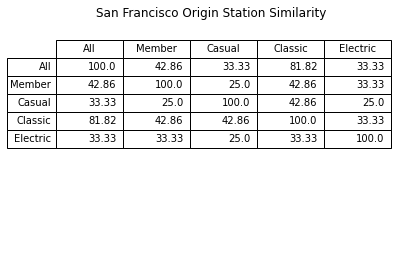

In [19]:
# Make a table of SF origin stations
fig, ax = plt.subplots() 
ax.set_axis_off()

title_text = 'San Francisco Origin Station Similarity'
plt.suptitle(title_text)
sf_start_table = ax.table(cellText=sf_start_mat, rowLabels=category_labels, rowLoc='right', colLabels=category_labels,
                     loc ='upper left')
sf_start_table.scale(1, 1.5)

The rankings for classic bike stations were similar to the station total, but all of the other similarities are much lower. The lowest similarity is between member and casual rider rankings: we noticed several differences between these groups earlier.

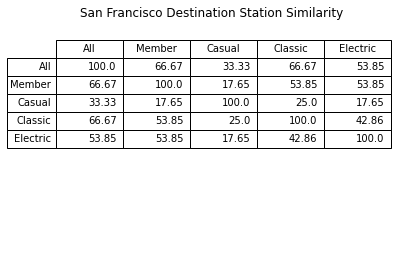

In [20]:
# Make a table of SF destination stations
fig, ax = plt.subplots() 
ax.set_axis_off()

title_text = 'San Francisco Destination Station Similarity'
plt.suptitle(title_text)
sf_end_table = ax.table(cellText=sf_end_mat, rowLabels=category_labels, rowLoc='right', colLabels=category_labels,
                     loc ='upper left')
sf_end_table.scale(1, 1.5)

Member and casual riders have an even lower similarity when we look at popular destinations, and none of the other groups are particularly similar here either.


## San Jose Data

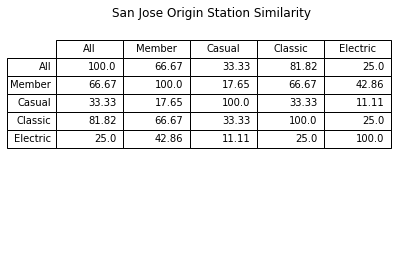

In [21]:
# Make a table of San Jose origin stations
fig, ax = plt.subplots() 
ax.set_axis_off()

title_text = 'San Jose Origin Station Similarity'
plt.suptitle(title_text)
sj_start_table = ax.table(cellText=sj_start_mat, rowLabels=category_labels, rowLoc='right', colLabels=category_labels,
                     loc ='upper left')
sj_start_table.scale(1, 1.5)

As in the San Francisco case, member and casual riders are by far the least similar, and the classic bike rankings match the overall rankings most closely.

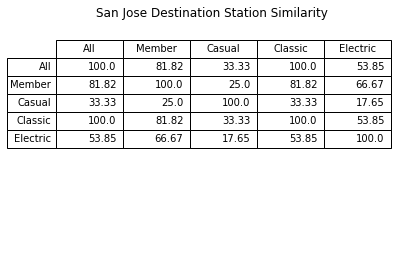

In [22]:
# Make a table of San Jose destination stations
fig, ax = plt.subplots() 
ax.set_axis_off()

title_text = 'San Jose Destination Station Similarity'
plt.suptitle(title_text)
sj_end_table = ax.table(cellText=sj_end_mat, rowLabels=category_labels, rowLoc='right', colLabels=category_labels,
                     loc ='upper left')
sj_end_table.scale(1, 1.5)

For destinations, classic bike rankings are a perfect match for the overall rankings, and the member rankings are also very close to overall.

## East Bay Data

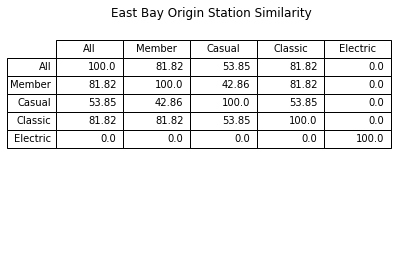

In [23]:
# Make a table of East Bay origin stations
fig, ax = plt.subplots() 
ax.set_axis_off()

title_text = 'East Bay Origin Station Similarity'
plt.suptitle(title_text)
eb_start_table = ax.table(cellText=eb_start_mat, rowLabels=category_labels, rowLoc='right', colLabels=category_labels,
                     loc ='upper left')
eb_start_table.scale(1, 1.5)

Here, we see much more similarity between the top rankings. Casual riders vs. members still shows the least similarity, but they're substantially more similar in this area.

As we noted before, there are no electric bikes in the East Bay. The fact that classic bike rankings aren't identical to the total rankings is strange, but there is a third category of bikes in the dataset: docked bikes. There are far fewer of this type of bike, and it isn't clear which category they should belong to. Based on this dissimilarity, it seems likely that these are classic bikes.

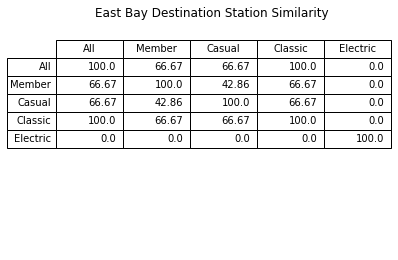

In [24]:
# Make a table of East Bay destination stations
fig, ax = plt.subplots() 
ax.set_axis_off()

title_text = 'East Bay Destination Station Similarity'
plt.suptitle(title_text)
eb_end_table = ax.table(cellText=eb_end_mat, rowLabels=category_labels, rowLoc='right', colLabels=category_labels,
                     loc ='upper left')
eb_end_table.scale(1, 1.5)

Classic bikes give identical rankings to the overall when it comes to destinations, so the docked bikes must have something to do with origin stations only. As with the origin station data, these lists are all fairly similar, at least compared to the other regions.

# Conclusions

Our Markov chain model did a good job of finding an odd isolated cluster of stations that has a potential problem of piling up bikes. These types of clusters are useful to watch, so that we can figure out ways to improve traffic flow in these areas if they're frequently problematic.

We saw some pretty big differences between the most popular stations for member and casual riders in San Francisco and San Jose, though not as much difference in the East Bay. This suggests some very different groups of users in these two areas. In San Francisco specifically, it looks like there might be a lot of member riders who are using the system to commute (to Lyft and Salesforce locations in particular) and there are some recognizable tourist destinations that are popular among casual users. San Jose might have a similar pattern, but it is difficult to tell without knowing station categories.

Classic and electric bikes had more similarity with their destination stations than they had with their origin stations in both San Jose and San Francisco. This may have something to do with where electric bikes are docked: there might not be as many potential origin stations for electric bikes. Electric bikes might also be more popular on uphill routes.

## Further Questions

Markov chains might be useful for looking at the traffic flow of classic and electric bikes separately as well, to make sure that these are well balanced. We also might want to look at which user groups tend to prefer classic or electric bikes, and possibly supply more of these bikes at stations which are popular with these user groups.

There are also some questions that we can't answer with the existing data set, but this initial analysis points us in some useful directions. If we could better categorize members based on which routes they tend to take, and identify users that look like tourists or are people on buisness trips, we could better determine which stations are popular with each of these groups. This wouldn't be possible without knowing less anonymized data, including some additional information about individual users (billing zip code, for example, could tell us if a user lives in the area or not.)

Categorizing stations based on what they're close to (e.g. businesses, shopping, entertainment, etc.) could also help to determine where future stations should be placed. We did see a few popular stations with more obvious locations. This would require matching locations with other geolocation data, which we don't currently have space for. Elevation data would also be useful to know, since elevation gain makes a much bigger difference when using a classic bike than it does with an electric bike.